In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy.stats import zscore
import matplotlib.pyplot as plt 
from statsmodels import regression
from statsmodels.tsa.stattools import coint

In [2]:
data = pd.read_excel('teste_pares.xlsx')

In [12]:
data = (data[300:])

In [13]:
data.head()

,time,IBOV,ABEV3,BBAS3,BBDC3,BBDC4,BBSE3,BRAP4,BRFS3,BRKM5,...,RAIL3,SANB11,SBSP3,SMLS3,TIMP3,UGPA3,USIM5,VALE3,VIVT4,WEGE3
300,2012-03-16,67684,11.63,17.67,9.00,10.25,NaN,22.84,35.06,11.07,...,33.33,10.87,18.14,NaN,9.08,16.41,12.78,31.20,31.11,4.86
301,2012-03-19,67730,11.84,17.58,8.89,10.15,NaN,23.03,35.46,10.91,...,33.22,10.60,18.43,NaN,9.21,16.39,12.88,31.42,31.46,4.92
302,2012-03-20,67296,11.97,17.53,8.78,10.01,NaN,22.67,34.60,10.79,...,32.54,10.54,18.34,NaN,9.12,16.13,12.89,30.94,31.25,4.83
303,2012-03-21,66868,12.01,17.22,8.76,10.03,NaN,22.55,34.17,10.75,...,32.65,10.29,18.33,NaN,9.29,16.56,12.38,30.83,31.30,4.93
304,2012-03-22,65828,12.21,16.66,8.78,10.00,NaN,22.24,33.95,10.56,...,32.31,10.03,18.51,NaN,9.22,16.44,12.22,30.19,30.80,4.80


In [4]:
class senninha_long_and_short():
    def __init__(self,dados,t1,t2, financeiro_inicial, zs_l):
        #temos o par de tickers, os dados históricos de preço, e as variações históricas.
        self.zs_critico = zs_l
        self.t1, self.t2 = t1,t2
        self.dados = dados[['time',t1,t2]]
        self.dados_var = dados[[t1,t2]].pct_change()[1:]
        self.dados = self.dados[1:]
        self.s1, self.s2 = self.dados[self.t1], self.dados[self.t2]
        self.s1_var, self.s2_var = self.dados_var[self.t1], self.dados_var[self.t2]
        self.financeiro = financeiro_inicial
        #variaveis iniciais para tradar pares
        self.posicionado = 0
        self.compra_s1 = 0
        self.venda_s2 = 0
        #desempenho ao longo do tempo 
        self.l_resultado = []
          
    def calcula_zscore_spread(self,stock1,stock2):
        stock1 = sm.add_constant(stock1)
        results = sm.OLS(stock2,stock1).fit()
        stock1 = stock1[self.t1]
        b = results.params[self.t1]
        spread = stock2 - (b*stock1)
        zs = zscore(spread)[-1]
        return zs, b
    
    def print_resultados(self, tipo, r): #rlong,rshort,result
        if tipo == 'entrada':
            print(f'entrou | V1 {self.venda_s1:.2f} X {self.v1} | C2 {self.compra_s2:.2f} X {self.v2}')
        elif tipo == 'saida':
            print(f'saiu   | C1 {self.compra_s1:.2f} X {self.v1} | V2 {self.venda_s2:.2f} X {self.v2}')
        elif tipo == 'resultado':
            print(f'result | s1 {r[0]:.2f} | s2 {r[1]:.2f} | l/p = {r[2]:.2f}\n')
    
    def condicoes_operar(self, zs_atual, cotacao1, cotacao2):
        if zs_atual >= self.zs_critico and self.posicionado == 0:
            razao = cotacao1/cotacao2
            volume = (self.financeiro/2)//cotacao1
            self.v1, self.v2 = int(volume), int(razao*volume)
            #definiu o numero de ações que comprará de cada
            self.venda_s1 = cotacao1*self.v1
            self.compra_s2  = cotacao2*self.v2 
            #self.financeiro += (self.venda_s2 - self.compra_s1)
            #self.print_resultados('entrada',r=None)
            self.posicionado = 1
        elif zs_atual <= 0.08 and self.posicionado == 1:
            self.posicionado = 0            
            #encerra posicao
            self.compra_s1 = cotacao1*self.v1
            self.venda_s2  = cotacao2*self.v2 
            #self.financeiro += (self.venda_s1 - self.compra_s2)
            #self.print_resultados('saida',r=None)
            #resultado
            resultado_long  = self.venda_s1 - self.compra_s1
            resultado_short = self.venda_s2 - self.compra_s2
            resultado = resultado_long + resultado_short
            self.l_resultado.append(resultado)
            #self.print_resultados('resultado',[resultado_long,resultado_short,resultado])
            self.financeiro += resultado
            #reseta valor em carteira de cada ação
            self.compra_s1, self.venda_s1, self.compra_s2 ,self.venda_s2,  = 0, 0, 0, 0
            resultado, resultado_long, resultado_short = 0, 0, 0
            
    def loop_operador(self, window_size):
        c = 0
        for index in range(window_size, len(self.s1)):
            try:
                #stock data in the window range
                s1_var_w, s2_var_w = self.s1_var[c:index], self.s2_var[c:index]
                preco_s1, preco_s2 = self.s1[self.dados.index == index].values[0], self.s2[self.dados.index == index].values[0]
                #calculates the zscore of the spread
                resultado_funcao = self.calcula_zscore_spread(s1_var_w, s2_var_w)
                zs, beta = resultado_funcao[0], resultado_funcao[1]
                self.condicoes_operar(zs_atual=zs, cotacao1=preco_s1, cotacao2=preco_s2)
            except:
                print(f'erro com {self.t1} x {self.t2}')    
            c+=1

In [5]:
l_pares = []
tickers = data.columns.to_list()
for i in range(2,len(tickers)-1): #todas os tickers 
    for j in range(i+1, len(tickers)): #todas as possibilidades de pares
        #print(tickers[i],tickers[j])
        l_pares.append([tickers[i],tickers[j]])

In [6]:
len(l_pares)

1485

In [16]:
zsl = 1.1
dic_dados_pares = {}

for i in l_pares[33:46]:
    dic_dados_pares[str(i)] = senninha_long_and_short(data,i[0], i[1], 1000,zs_l = zsl)
    dic_dados_pares[str(i)].loop_operador(window_size=45)
    print(i)

erro com ABEV3 x LAME4
erro com ABEV3 x LAME4
erro com ABEV3 x LAME4
erro com ABEV3 x LAME4
erro com ABEV3 x LAME4
erro com ABEV3 x LAME4
erro com ABEV3 x LAME4
erro com ABEV3 x LAME4
erro com ABEV3 x LAME4
erro com ABEV3 x LAME4
erro com ABEV3 x LAME4
erro com ABEV3 x LAME4
erro com ABEV3 x LAME4
erro com ABEV3 x LAME4
erro com ABEV3 x LAME4
erro com ABEV3 x LAME4
erro com ABEV3 x LAME4
erro com ABEV3 x LAME4
erro com ABEV3 x LAME4
erro com ABEV3 x LAME4
erro com ABEV3 x LAME4
erro com ABEV3 x LAME4
erro com ABEV3 x LAME4
erro com ABEV3 x LAME4
erro com ABEV3 x LAME4
erro com ABEV3 x LAME4
erro com ABEV3 x LAME4
erro com ABEV3 x LAME4
erro com ABEV3 x LAME4
erro com ABEV3 x LAME4
erro com ABEV3 x LAME4
erro com ABEV3 x LAME4
erro com ABEV3 x LAME4
erro com ABEV3 x LAME4
erro com ABEV3 x LAME4
erro com ABEV3 x LAME4
erro com ABEV3 x LAME4
erro com ABEV3 x LAME4
erro com ABEV3 x LAME4
erro com ABEV3 x LAME4
erro com ABEV3 x LAME4
erro com ABEV3 x LAME4
erro com ABEV3 x LAME4
erro com AB

erro com ABEV3 x LREN3
erro com ABEV3 x LREN3
erro com ABEV3 x LREN3
erro com ABEV3 x LREN3
erro com ABEV3 x LREN3
erro com ABEV3 x LREN3
erro com ABEV3 x LREN3
erro com ABEV3 x LREN3
erro com ABEV3 x LREN3
erro com ABEV3 x LREN3
erro com ABEV3 x LREN3
erro com ABEV3 x LREN3
erro com ABEV3 x LREN3
erro com ABEV3 x LREN3
erro com ABEV3 x LREN3
erro com ABEV3 x LREN3
erro com ABEV3 x LREN3
erro com ABEV3 x LREN3
erro com ABEV3 x LREN3
erro com ABEV3 x LREN3
erro com ABEV3 x LREN3
erro com ABEV3 x LREN3
erro com ABEV3 x LREN3
erro com ABEV3 x LREN3
erro com ABEV3 x LREN3
erro com ABEV3 x LREN3
erro com ABEV3 x LREN3
erro com ABEV3 x LREN3
erro com ABEV3 x LREN3
erro com ABEV3 x LREN3
erro com ABEV3 x LREN3
erro com ABEV3 x LREN3
erro com ABEV3 x LREN3
erro com ABEV3 x LREN3
erro com ABEV3 x LREN3
erro com ABEV3 x LREN3
erro com ABEV3 x LREN3
erro com ABEV3 x LREN3
erro com ABEV3 x LREN3
erro com ABEV3 x LREN3
erro com ABEV3 x LREN3
erro com ABEV3 x LREN3
erro com ABEV3 x LREN3
erro com AB

['ABEV3', 'MRFG3']
erro com ABEV3 x MRVE3
erro com ABEV3 x MRVE3
erro com ABEV3 x MRVE3
erro com ABEV3 x MRVE3
erro com ABEV3 x MRVE3
erro com ABEV3 x MRVE3
erro com ABEV3 x MRVE3
erro com ABEV3 x MRVE3
erro com ABEV3 x MRVE3
erro com ABEV3 x MRVE3
erro com ABEV3 x MRVE3
erro com ABEV3 x MRVE3
erro com ABEV3 x MRVE3
erro com ABEV3 x MRVE3
erro com ABEV3 x MRVE3
erro com ABEV3 x MRVE3
erro com ABEV3 x MRVE3
erro com ABEV3 x MRVE3
erro com ABEV3 x MRVE3
erro com ABEV3 x MRVE3
erro com ABEV3 x MRVE3
erro com ABEV3 x MRVE3
erro com ABEV3 x MRVE3
erro com ABEV3 x MRVE3
erro com ABEV3 x MRVE3
erro com ABEV3 x MRVE3
erro com ABEV3 x MRVE3
erro com ABEV3 x MRVE3
erro com ABEV3 x MRVE3
erro com ABEV3 x MRVE3
erro com ABEV3 x MRVE3
erro com ABEV3 x MRVE3
erro com ABEV3 x MRVE3
erro com ABEV3 x MRVE3
erro com ABEV3 x MRVE3
erro com ABEV3 x MRVE3
erro com ABEV3 x MRVE3
erro com ABEV3 x MRVE3
erro com ABEV3 x MRVE3
erro com ABEV3 x MRVE3
erro com ABEV3 x MRVE3
erro com ABEV3 x MRVE3
erro com ABEV3 

erro com ABEV3 x MULT3
erro com ABEV3 x MULT3
erro com ABEV3 x MULT3
erro com ABEV3 x MULT3
erro com ABEV3 x MULT3
erro com ABEV3 x MULT3
erro com ABEV3 x MULT3
erro com ABEV3 x MULT3
erro com ABEV3 x MULT3
erro com ABEV3 x MULT3
erro com ABEV3 x MULT3
erro com ABEV3 x MULT3
erro com ABEV3 x MULT3
erro com ABEV3 x MULT3
erro com ABEV3 x MULT3
erro com ABEV3 x MULT3
erro com ABEV3 x MULT3
erro com ABEV3 x MULT3
erro com ABEV3 x MULT3
erro com ABEV3 x MULT3
erro com ABEV3 x MULT3
erro com ABEV3 x MULT3
erro com ABEV3 x MULT3
erro com ABEV3 x MULT3
erro com ABEV3 x MULT3
erro com ABEV3 x MULT3
erro com ABEV3 x MULT3
erro com ABEV3 x MULT3
erro com ABEV3 x MULT3
erro com ABEV3 x MULT3
erro com ABEV3 x MULT3
erro com ABEV3 x MULT3
erro com ABEV3 x MULT3
erro com ABEV3 x MULT3
erro com ABEV3 x MULT3
erro com ABEV3 x MULT3
erro com ABEV3 x MULT3
erro com ABEV3 x MULT3
erro com ABEV3 x MULT3
erro com ABEV3 x MULT3
erro com ABEV3 x MULT3
erro com ABEV3 x MULT3
erro com ABEV3 x MULT3
erro com AB

erro com ABEV3 x NTCO3
erro com ABEV3 x NTCO3
erro com ABEV3 x NTCO3
erro com ABEV3 x NTCO3
erro com ABEV3 x NTCO3
erro com ABEV3 x NTCO3
erro com ABEV3 x NTCO3
erro com ABEV3 x NTCO3
erro com ABEV3 x NTCO3
erro com ABEV3 x NTCO3
erro com ABEV3 x NTCO3
erro com ABEV3 x NTCO3
erro com ABEV3 x NTCO3
erro com ABEV3 x NTCO3
['ABEV3', 'NTCO3']
erro com ABEV3 x PETR3
erro com ABEV3 x PETR3
erro com ABEV3 x PETR3
erro com ABEV3 x PETR3
erro com ABEV3 x PETR3
erro com ABEV3 x PETR3
erro com ABEV3 x PETR3
erro com ABEV3 x PETR3
erro com ABEV3 x PETR3
erro com ABEV3 x PETR3
erro com ABEV3 x PETR3
erro com ABEV3 x PETR3
erro com ABEV3 x PETR3
erro com ABEV3 x PETR3
erro com ABEV3 x PETR3
erro com ABEV3 x PETR3
erro com ABEV3 x PETR3
erro com ABEV3 x PETR3
erro com ABEV3 x PETR3
erro com ABEV3 x PETR3
erro com ABEV3 x PETR3
erro com ABEV3 x PETR3
erro com ABEV3 x PETR3
erro com ABEV3 x PETR3
erro com ABEV3 x PETR3
erro com ABEV3 x PETR3
erro com ABEV3 x PETR3
erro com ABEV3 x PETR3
erro com ABEV3 

erro com ABEV3 x PETR4
erro com ABEV3 x PETR4
erro com ABEV3 x PETR4
erro com ABEV3 x PETR4
erro com ABEV3 x PETR4
erro com ABEV3 x PETR4
erro com ABEV3 x PETR4
erro com ABEV3 x PETR4
erro com ABEV3 x PETR4
erro com ABEV3 x PETR4
erro com ABEV3 x PETR4
erro com ABEV3 x PETR4
erro com ABEV3 x PETR4
erro com ABEV3 x PETR4
erro com ABEV3 x PETR4
erro com ABEV3 x PETR4
erro com ABEV3 x PETR4
erro com ABEV3 x PETR4
erro com ABEV3 x PETR4
erro com ABEV3 x PETR4
erro com ABEV3 x PETR4
erro com ABEV3 x PETR4
erro com ABEV3 x PETR4
erro com ABEV3 x PETR4
erro com ABEV3 x PETR4
erro com ABEV3 x PETR4
erro com ABEV3 x PETR4
erro com ABEV3 x PETR4
erro com ABEV3 x PETR4
erro com ABEV3 x PETR4
erro com ABEV3 x PETR4
erro com ABEV3 x PETR4
erro com ABEV3 x PETR4
erro com ABEV3 x PETR4
erro com ABEV3 x PETR4
erro com ABEV3 x PETR4
erro com ABEV3 x PETR4
erro com ABEV3 x PETR4
erro com ABEV3 x PETR4
erro com ABEV3 x PETR4
erro com ABEV3 x PETR4
erro com ABEV3 x PETR4
erro com ABEV3 x PETR4
erro com AB

['ABEV3', 'QUAL3']
erro com ABEV3 x RADL3
erro com ABEV3 x RADL3
erro com ABEV3 x RADL3
erro com ABEV3 x RADL3
erro com ABEV3 x RADL3
erro com ABEV3 x RADL3
erro com ABEV3 x RADL3
erro com ABEV3 x RADL3
erro com ABEV3 x RADL3
erro com ABEV3 x RADL3
erro com ABEV3 x RADL3
erro com ABEV3 x RADL3
erro com ABEV3 x RADL3
erro com ABEV3 x RADL3
erro com ABEV3 x RADL3
erro com ABEV3 x RADL3
erro com ABEV3 x RADL3
erro com ABEV3 x RADL3
erro com ABEV3 x RADL3
erro com ABEV3 x RADL3
erro com ABEV3 x RADL3
erro com ABEV3 x RADL3
erro com ABEV3 x RADL3
erro com ABEV3 x RADL3
erro com ABEV3 x RADL3
erro com ABEV3 x RADL3
erro com ABEV3 x RADL3
erro com ABEV3 x RADL3
erro com ABEV3 x RADL3
erro com ABEV3 x RADL3
erro com ABEV3 x RADL3
erro com ABEV3 x RADL3
erro com ABEV3 x RADL3
erro com ABEV3 x RADL3
erro com ABEV3 x RADL3
erro com ABEV3 x RADL3
erro com ABEV3 x RADL3
erro com ABEV3 x RADL3
erro com ABEV3 x RADL3
erro com ABEV3 x RADL3
erro com ABEV3 x RADL3
erro com ABEV3 x RADL3
erro com ABEV3 

erro com ABEV3 x RENT3
erro com ABEV3 x RENT3
erro com ABEV3 x RENT3
erro com ABEV3 x RENT3
erro com ABEV3 x RENT3
erro com ABEV3 x RENT3
erro com ABEV3 x RENT3
erro com ABEV3 x RENT3
erro com ABEV3 x RENT3
erro com ABEV3 x RENT3
erro com ABEV3 x RENT3
erro com ABEV3 x RENT3
erro com ABEV3 x RENT3
erro com ABEV3 x RENT3
erro com ABEV3 x RENT3
erro com ABEV3 x RENT3
erro com ABEV3 x RENT3
erro com ABEV3 x RENT3
erro com ABEV3 x RENT3
erro com ABEV3 x RENT3
erro com ABEV3 x RENT3
erro com ABEV3 x RENT3
erro com ABEV3 x RENT3
erro com ABEV3 x RENT3
erro com ABEV3 x RENT3
erro com ABEV3 x RENT3
erro com ABEV3 x RENT3
erro com ABEV3 x RENT3
erro com ABEV3 x RENT3
erro com ABEV3 x RENT3
erro com ABEV3 x RENT3
erro com ABEV3 x RENT3
erro com ABEV3 x RENT3
erro com ABEV3 x RENT3
erro com ABEV3 x RENT3
erro com ABEV3 x RENT3
erro com ABEV3 x RENT3
erro com ABEV3 x RENT3
erro com ABEV3 x RENT3
erro com ABEV3 x RENT3
erro com ABEV3 x RENT3
erro com ABEV3 x RENT3
erro com ABEV3 x RENT3
erro com AB

c:\users\danie\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in double_scalars


erro com ABEV3 x RAIL3
erro com ABEV3 x RAIL3
erro com ABEV3 x RAIL3
['ABEV3', 'RAIL3']
erro com ABEV3 x SANB11
erro com ABEV3 x SANB11
erro com ABEV3 x SANB11
erro com ABEV3 x SANB11
erro com ABEV3 x SANB11
erro com ABEV3 x SANB11
erro com ABEV3 x SANB11
erro com ABEV3 x SANB11
erro com ABEV3 x SANB11
erro com ABEV3 x SANB11
erro com ABEV3 x SANB11
erro com ABEV3 x SANB11
erro com ABEV3 x SANB11
erro com ABEV3 x SANB11
erro com ABEV3 x SANB11
erro com ABEV3 x SANB11
erro com ABEV3 x SANB11
erro com ABEV3 x SANB11
erro com ABEV3 x SANB11
erro com ABEV3 x SANB11
erro com ABEV3 x SANB11
erro com ABEV3 x SANB11
erro com ABEV3 x SANB11
erro com ABEV3 x SANB11
erro com ABEV3 x SANB11
erro com ABEV3 x SANB11
erro com ABEV3 x SANB11
erro com ABEV3 x SANB11
erro com ABEV3 x SANB11
erro com ABEV3 x SANB11
erro com ABEV3 x SANB11
erro com ABEV3 x SANB11
erro com ABEV3 x SANB11
erro com ABEV3 x SANB11
erro com ABEV3 x SANB11
erro com ABEV3 x SANB11
erro com ABEV3 x SANB11
erro com ABEV3 x SANB11


In [17]:
for k,v in dic_dados_pares.items():
    print(f'{k}: {v.financeiro:.2f}')

['ABEV3', 'LAME4']: 971.71
['ABEV3', 'LREN3']: 918.90
['ABEV3', 'MRFG3']: 1078.09
['ABEV3', 'MRVE3']: 685.50
['ABEV3', 'MULT3']: 819.28
['ABEV3', 'NTCO3']: 944.95
['ABEV3', 'PETR3']: 863.33
['ABEV3', 'PETR4']: 779.51
['ABEV3', 'QUAL3']: 992.85
['ABEV3', 'RADL3']: 1064.94
['ABEV3', 'RENT3']: 910.72
['ABEV3', 'RAIL3']: nan
['ABEV3', 'SANB11']: 989.15


In [ ]:
dic

In [26]:
fig = plt.figure(figsize=(10, 25))
plt.subplots_adjust(left=None, bottom=0, right=None, top=None, wspace=None, hspace=.5)
contador1 = 1

for k,v in dic_dados_pares.items():
    print(f'{k}: {v.financeiro:.2f}')
    plt.subplot(8, 1, contador1)
    plt.title('Ganho em R$ ao longo dos trades '+ k)
    plt.xlabel('Numero da Operacao')
    plt.ylabel('R$')
    plt.plot(v.l_resultado)
    contador1 += 1


[['ABEV3', 'BBAS3'], ['ABEV3', 'BBDC3'], ['ABEV3', 'BBDC4'], ['ABEV3', 'BBSE3'], ['ABEV3', 'BRAP4'], ['ABEV3', 'BRFS3'], ['ABEV3', 'BRKM5'], ['ABEV3', 'BRML3'], ['ABEV3', 'B3SA3'], ['ABEV3', 'CCRO3'], ['ABEV3', 'CIEL3'], ['ABEV3', 'CMIG4'], ['ABEV3', 'CPFE3'], ['ABEV3', 'CPLE6'], ['ABEV3', 'CSAN3'], ['ABEV3', 'CSNA3'], ['ABEV3', 'CYRE3'], ['ABEV3', 'ECOR3'], ['ABEV3', 'EGIE3'], ['ABEV3', 'ELET3'], ['ABEV3', 'EMBR3'], ['ABEV3', 'ENBR3'], ['ABEV3', 'EQTL3'], ['ABEV3', 'YDUQ3'], ['ABEV3', 'SUZB3'], ['ABEV3', 'GGBR4'], ['ABEV3', 'GOAU4'], ['ABEV3', 'HYPE3'], ['ABEV3', 'ITSA4'], ['ABEV3', 'ITUB4'], ['ABEV3', 'JBSS3'], ['ABEV3', 'KLBN11'], ['ABEV3', 'COGN3'], ['ABEV3', 'LAME4'], ['ABEV3', 'LREN3'], ['ABEV3', 'MRFG3'], ['ABEV3', 'MRVE3'], ['ABEV3', 'MULT3'], ['ABEV3', 'NTCO3'], ['ABEV3', 'PETR3'], ['ABEV3', 'PETR4'], ['ABEV3', 'QUAL3'], ['ABEV3', 'RADL3'], ['ABEV3', 'RENT3'], ['ABEV3', 'RAIL3'], ['ABEV3', 'SANB11'], ['ABEV3', 'SBSP3'], ['ABEV3', 'SMLS3'], ['ABEV3', 'TIMP3'], ['ABEV3', 'UGPA3'

In [30]:
zsl = 1.1
dic_dados_pares = {}

tickers = [['VALE3','ITSA4'],['ECOR3','GOAU4'],['CSNA3','MRFG3'],['QUAL3','USIM5']] #['close VALE3','close ITSA4'],['close BBAS3','close BBSE3'],['close BBDC4','close ITUB4']
for i in tickers:
    dic_dados_pares[str(i)] = senninha_long_and_short(data,i[0], i[1], 1000,zs_l = zsl)
    dic_dados_pares[str(i)].loop_operador(window_size=45)


entrou | V1 499.66 X 14 | C2 496.49 X 131
saiu   | C1 487.06 X 14 | V2 486.01 X 131
result | s1 12.60 | s2 -10.48 | l/p = 2.12

entrou | V1 469.69 X 13 | C2 468.00 X 120
saiu   | C1 476.71 X 13 | V2 464.40 X 120
result | s1 -7.02 | s2 -3.60 | l/p = -10.62

entrou | V1 471.51 X 13 | C2 468.00 X 117
saiu   | C1 482.69 X 13 | V2 483.21 X 117
result | s1 -11.18 | s2 15.21 | l/p = 4.03

entrou | V1 483.28 X 14 | C2 482.36 X 124
saiu   | C1 485.24 X 14 | V2 482.36 X 124
result | s1 -1.96 | s2 0.00 | l/p = -1.96

entrou | V1 477.54 X 14 | C2 477.30 X 129
saiu   | C1 478.66 X 14 | V2 474.72 X 129
result | s1 -1.12 | s2 -2.58 | l/p = -3.70

entrou | V1 486.22 X 14 | C2 485.12 X 128
saiu   | C1 489.16 X 14 | V2 482.56 X 128
result | s1 -2.94 | s2 -2.56 | l/p = -5.50

entrou | V1 488.18 X 14 | C2 485.14 X 127
saiu   | C1 483.42 X 14 | V2 480.06 X 127
result | s1 4.76 | s2 -5.08 | l/p = -0.32

entrou | V1 475.58 X 14 | C2 472.50 X 125
saiu   | C1 476.00 X 14 | V2 472.50 X 125
result | s1 -0.42 | s

saiu   | C1 454.24 X 16 | V2 452.52 X 108
result | s1 1.60 | s2 -1.08 | l/p = 0.52

entrou | V1 432.00 X 15 | C2 431.21 X 107
saiu   | C1 432.90 X 15 | V2 435.49 X 107
result | s1 -0.90 | s2 4.28 | l/p = 3.38

entrou | V1 444.16 X 16 | C2 440.36 X 109
saiu   | C1 456.48 X 16 | V2 437.09 X 109
result | s1 -12.32 | s2 -3.27 | l/p = -15.59

entrou | V1 432.45 X 15 | C2 431.79 X 111
saiu   | C1 430.65 X 15 | V2 434.01 X 111
result | s1 1.80 | s2 2.22 | l/p = 4.02

entrou | V1 453.42 X 18 | C2 450.00 X 120
saiu   | C1 464.22 X 18 | V2 448.80 X 120
result | s1 -10.80 | s2 -1.20 | l/p = -12.00

entrou | V1 428.91 X 17 | C2 425.50 X 115
saiu   | C1 437.58 X 17 | V2 425.50 X 115
result | s1 -8.67 | s2 0.00 | l/p = -8.67

entrou | V1 428.64 X 16 | C2 427.80 X 115
saiu   | C1 416.80 X 16 | V2 417.45 X 115
result | s1 11.84 | s2 -10.35 | l/p = 1.49

entrou | V1 423.68 X 16 | C2 422.40 X 110
saiu   | C1 434.56 X 16 | V2 420.20 X 110
result | s1 -10.88 | s2 -2.20 | l/p = -13.08

entrou | V1 424.65 X

saiu   | C1 393.30 X 30 | V2 396.80 X 80
result | s1 14.40 | s2 -9.60 | l/p = 4.80

entrou | V1 405.12 X 32 | C2 400.92 X 78
saiu   | C1 389.12 X 32 | V2 405.60 X 78
result | s1 16.00 | s2 4.68 | l/p = 20.68

entrou | V1 420.60 X 30 | C2 416.33 X 79
saiu   | C1 416.10 X 30 | V2 415.54 X 79
result | s1 4.50 | s2 -0.79 | l/p = 3.71

entrou | V1 411.60 X 30 | C2 409.22 X 79
saiu   | C1 421.80 X 30 | V2 410.01 X 79
result | s1 -10.20 | s2 0.79 | l/p = -9.41

entrou | V1 411.32 X 28 | C2 408.24 X 81
saiu   | C1 429.80 X 28 | V2 409.05 X 81
result | s1 -18.48 | s2 0.81 | l/p = -17.67

entrou | V1 401.80 X 28 | C2 399.76 X 76
saiu   | C1 403.76 X 28 | V2 397.48 X 76
result | s1 -1.96 | s2 -2.28 | l/p = -4.24

entrou | V1 404.73 X 27 | C2 404.19 X 81
saiu   | C1 365.04 X 27 | V2 392.04 X 81
result | s1 39.69 | s2 -12.15 | l/p = 27.54

entrou | V1 413.10 X 30 | C2 411.60 X 84
saiu   | C1 414.60 X 30 | V2 405.72 X 84
result | s1 -1.50 | s2 -5.88 | l/p = -7.38

entrou | V1 405.00 X 27 | C2 405.00

entrou | V1 513.42 X 43 | C2 508.04 X 26
saiu   | C1 526.32 X 43 | V2 507.52 X 26
result | s1 -12.90 | s2 -0.52 | l/p = -13.42

entrou | V1 511.27 X 41 | C2 497.50 X 25
saiu   | C1 505.53 X 41 | V2 488.75 X 25
result | s1 5.74 | s2 -8.75 | l/p = -3.01

entrou | V1 500.22 X 42 | C2 495.56 X 26
saiu   | C1 500.22 X 42 | V2 486.98 X 26
result | s1 0.00 | s2 -8.58 | l/p = -8.58

entrou | V1 494.76 X 42 | C2 488.43 X 27
saiu   | C1 488.88 X 42 | V2 484.11 X 27
result | s1 5.88 | s2 -4.32 | l/p = 1.56

entrou | V1 500.64 X 42 | C2 484.12 X 28
saiu   | C1 501.90 X 42 | V2 483.56 X 28
result | s1 -1.26 | s2 -0.56 | l/p = -1.82

entrou | V1 493.92 X 42 | C2 479.92 X 28
saiu   | C1 500.64 X 42 | V2 466.48 X 28
result | s1 -6.72 | s2 -13.44 | l/p = -20.16

entrou | V1 492.66 X 42 | C2 492.60 X 30
saiu   | C1 509.04 X 42 | V2 516.30 X 30
result | s1 -16.38 | s2 23.70 | l/p = 7.32

entrou | V1 489.95 X 41 | C2 485.80 X 28
saiu   | C1 501.02 X 41 | V2 486.08 X 28
result | s1 -11.07 | s2 0.28 | l/p =

entrou | V1 484.16 X 89 | C2 482.79 X 133
saiu   | C1 469.03 X 89 | V2 481.46 X 133
result | s1 15.13 | s2 -1.33 | l/p = 13.80

entrou | V1 491.52 X 96 | C2 489.18 X 186
saiu   | C1 522.24 X 96 | V2 472.44 X 186
result | s1 -30.72 | s2 -16.74 | l/p = -47.46

entrou | V1 467.40 X 95 | C2 466.20 X 252
saiu   | C1 457.90 X 95 | V2 453.60 X 252
result | s1 9.50 | s2 -12.60 | l/p = -3.10

entrou | V1 462.33 X 99 | C2 462.24 X 321
saiu   | C1 407.88 X 99 | V2 481.50 X 321
result | s1 54.45 | s2 19.26 | l/p = 73.71

entrou | V1 499.82 X 134 | C2 499.59 X 427
saiu   | C1 501.16 X 134 | V2 486.78 X 427
result | s1 -1.34 | s2 -12.81 | l/p = -14.15

entrou | V1 493.68 X 136 | C2 493.50 X 470
saiu   | C1 478.72 X 136 | V2 484.10 X 470
result | s1 14.96 | s2 -9.40 | l/p = 5.56

entrou | V1 497.00 X 142 | C2 496.80 X 460
saiu   | C1 501.26 X 142 | V2 542.80 X 460
result | s1 -4.26 | s2 46.00 | l/p = 41.74

entrou | V1 519.68 X 116 | C2 518.40 X 384
saiu   | C1 545.20 X 116 | V2 741.12 X 384
result |

entrou | V1 856.08 X 116 | C2 848.12 X 91
saiu   | C1 830.56 X 116 | V2 850.85 X 91
result | s1 25.52 | s2 2.73 | l/p = 28.25

entrou | V1 873.76 X 127 | C2 871.38 X 94
saiu   | C1 829.31 X 127 | V2 846.94 X 94
result | s1 44.45 | s2 -24.44 | l/p = 20.01

entrou | V1 885.02 X 137 | C2 878.82 X 97
saiu   | C1 875.43 X 137 | V2 854.57 X 97
result | s1 9.59 | s2 -24.25 | l/p = -14.66

entrou | V1 876.69 X 153 | C2 872.92 X 139
saiu   | C1 881.28 X 153 | V2 860.41 X 139
result | s1 -4.59 | s2 -12.51 | l/p = -17.10

entrou | V1 865.23 X 151 | C2 862.96 X 134
saiu   | C1 881.84 X 151 | V2 864.30 X 134
result | s1 -16.61 | s2 1.34 | l/p = -15.27

entrou | V1 858.24 X 149 | C2 852.48 X 128
saiu   | C1 846.32 X 149 | V2 823.04 X 128
result | s1 11.92 | s2 -29.44 | l/p = -17.52

entrou | V1 851.13 X 147 | C2 849.24 X 126
saiu   | C1 818.79 X 147 | V2 856.80 X 126
result | s1 32.34 | s2 7.56 | l/p = 39.90

entrou | V1 870.07 X 167 | C2 869.82 X 133
saiu   | C1 819.97 X 167 | V2 1006.81 X 133
resu

entrou | V1 1754.97 X 411 | C2 1752.40 X 260
saiu   | C1 1754.97 X 411 | V2 1729.00 X 260
result | s1 0.00 | s2 -23.40 | l/p = -23.40

entrou | V1 1742.51 X 511 | C2 1739.50 X 245
saiu   | C1 1640.31 X 511 | V2 1565.55 X 245
result | s1 102.20 | s2 -173.95 | l/p = -71.75

entrou | V1 1708.88 X 521 | C2 1703.52 X 252
saiu   | C1 1849.55 X 521 | V2 1711.08 X 252
result | s1 -140.67 | s2 7.56 | l/p = -133.11

entrou | V1 1638.42 X 329 | C2 1632.50 X 250
saiu   | C1 1743.70 X 329 | V2 1607.50 X 250
result | s1 -105.28 | s2 -25.00 | l/p = -130.28

entrou | V1 1576.12 X 364 | C2 1574.72 X 259
saiu   | C1 1539.72 X 364 | V2 1561.77 X 259
result | s1 36.40 | s2 -12.95 | l/p = 23.45

entrou | V1 1586.72 X 376 | C2 1584.64 X 256
saiu   | C1 1451.36 X 376 | V2 1587.20 X 256
result | s1 135.36 | s2 2.56 | l/p = 137.92

entrou | V1 1656.48 X 476 | C2 1654.27 X 263
saiu   | C1 1594.60 X 476 | V2 1622.71 X 263
result | s1 61.88 | s2 -31.56 | l/p = 30.32

entrou | V1 1672.11 X 563 | C2 1670.24 X 286
s

saiu   | C1 434.30 X 43 | V2 452.76 X 44
result | s1 21.50 | s2 0.88 | l/p = 22.38

entrou | V1 472.12 X 44 | C2 463.54 X 43
saiu   | C1 467.72 X 44 | V2 470.42 X 43
result | s1 4.40 | s2 6.88 | l/p = 11.28

entrou | V1 478.35 X 45 | C2 469.45 X 41
saiu   | C1 470.25 X 45 | V2 461.66 X 41
result | s1 8.10 | s2 -7.79 | l/p = 0.31

entrou | V1 480.42 X 51 | C2 469.04 X 41
saiu   | C1 456.45 X 51 | V2 467.81 X 41
result | s1 23.97 | s2 -1.23 | l/p = 22.74

entrou | V1 485.59 X 49 | C2 477.66 X 38
saiu   | C1 479.71 X 49 | V2 489.82 X 38
result | s1 5.88 | s2 12.16 | l/p = 18.04

entrou | V1 494.70 X 51 | C2 489.72 X 42
saiu   | C1 492.66 X 51 | V2 480.06 X 42
result | s1 2.04 | s2 -9.66 | l/p = -7.62

entrou | V1 498.72 X 48 | C2 497.70 X 45
saiu   | C1 507.36 X 48 | V2 498.60 X 45
result | s1 -8.64 | s2 0.90 | l/p = -7.74

entrou | V1 493.65 X 45 | C2 484.50 X 51
saiu   | C1 471.60 X 45 | V2 458.49 X 51
result | s1 22.05 | s2 -26.01 | l/p = -3.96

entrou | V1 493.12 X 46 | C2 487.60 X 53

entrou | V1 438.48 X 28 | C2 436.59 X 81
saiu   | C1 448.56 X 28 | V2 428.49 X 81
result | s1 -10.08 | s2 -8.10 | l/p = -18.18

entrou | V1 430.38 X 27 | C2 429.00 X 78
saiu   | C1 416.07 X 27 | V2 402.48 X 78
result | s1 14.31 | s2 -26.52 | l/p = -12.21

entrou | V1 414.99 X 27 | C2 411.16 X 76
saiu   | C1 416.07 X 27 | V2 398.24 X 76
result | s1 -1.08 | s2 -12.92 | l/p = -14.00

entrou | V1 412.02 X 27 | C2 409.22 X 79
saiu   | C1 418.77 X 27 | V2 380.78 X 79
result | s1 -6.75 | s2 -28.44 | l/p = -35.19

entrou | V1 396.72 X 24 | C2 392.70 X 77
saiu   | C1 404.88 X 24 | V2 401.17 X 77
result | s1 -8.16 | s2 8.47 | l/p = 0.31

entrou | V1 399.84 X 24 | C2 398.36 X 92
saiu   | C1 400.56 X 24 | V2 438.84 X 92
result | s1 -0.72 | s2 40.48 | l/p = 39.76

entrou | V1 419.50 X 25 | C2 416.24 X 88
saiu   | C1 413.75 X 25 | V2 395.12 X 88
result | s1 5.75 | s2 -21.12 | l/p = -15.37

entrou | V1 414.90 X 30 | C2 411.32 X 113
saiu   | C1 432.60 X 30 | V2 390.98 X 113
result | s1 -17.70 | s2 -20

['VALE3', 'ITSA4']: 774.02
['ECOR3', 'GOAU4']: 1026.95
['CSNA3', 'MRFG3']: 2895.51
['QUAL3', 'USIM5']: 1127.50


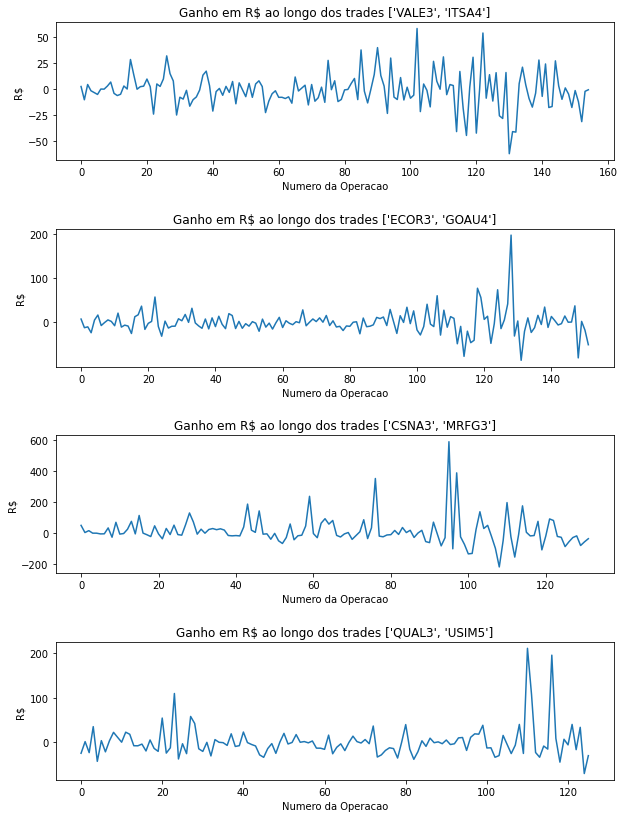

In [31]:
fig = plt.figure(figsize=(10, 25))
plt.subplots_adjust(left=None, bottom=0, right=None, top=None, wspace=None, hspace=.5)
contador1 = 1

for k,v in dic_dados_pares.items():
    print(f'{k}: {v.financeiro:.2f}')
    plt.subplot(8, 1, contador1)
    plt.title('Ganho em R$ ao longo dos trades '+ k)
    plt.xlabel('Numero da Operacao')
    plt.ylabel('R$')
    plt.plot(v.l_resultado)
    contador1 += 1
